In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS


In [12]:
uncertainty = pd.read_csv('../data/processed/uncertainty_index.csv')

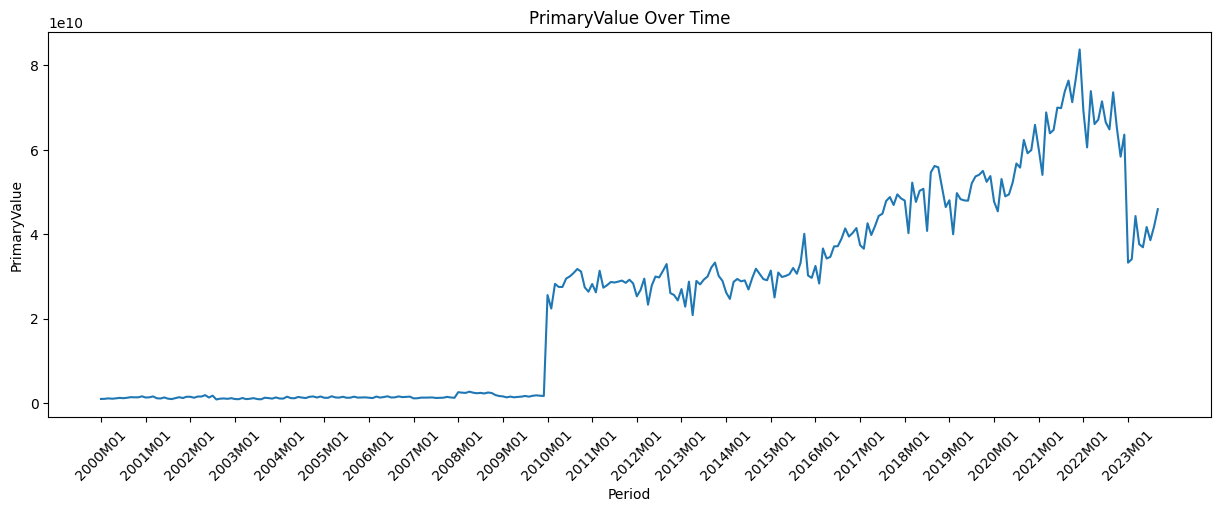

In [10]:
trade_volume = pd.read_csv('../data/processed/trade_volume.csv', encoding='unicode_escape')

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(trade_volume['period'], trade_volume['PrimaryValue'])
plt.xlabel('Period')
plt.ylabel('PrimaryValue')
plt.title('PrimaryValue Over Time')
plt.xticks(rotation=45)

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
plt.xticks(trade_volume['period'][::12], rotation=45)
plt.show()


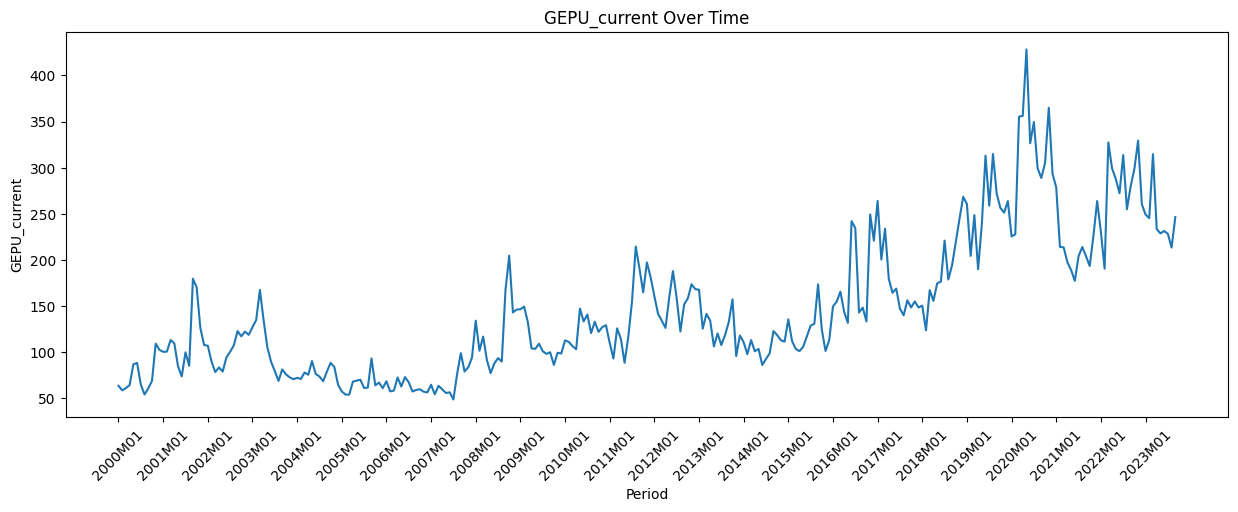

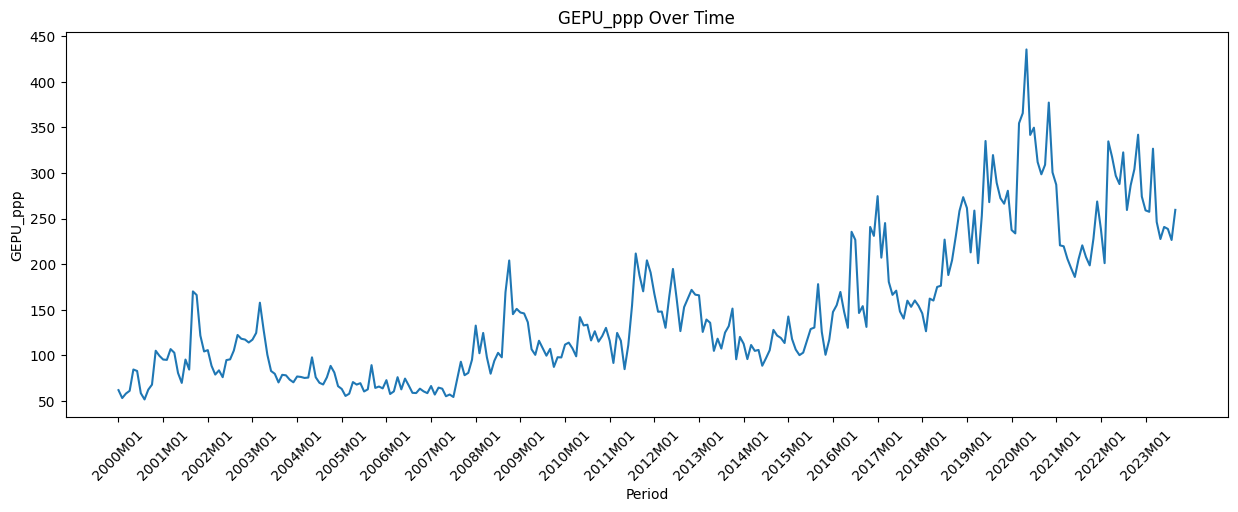

In [8]:
epu = pd.read_csv('../data/processed/epu.csv', encoding='unicode_escape')

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(epu['period'], epu['GEPU_current'])
plt.xlabel('Period')
plt.ylabel('GEPU_current')
plt.title('GEPU_current Over Time')
plt.xticks(rotation=45)

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
plt.xticks(epu['period'][::12], rotation=45)
plt.show()

# Plotting
plt.figure(figsize=(15, 5))
plt.plot(epu['period'], epu['GEPU_ppp'])
plt.xlabel('Period')
plt.ylabel('GEPU_ppp')
plt.title('GEPU_ppp Over Time')
plt.xticks(rotation=45)

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
plt.xticks(epu['period'][::12], rotation=45)
plt.show()

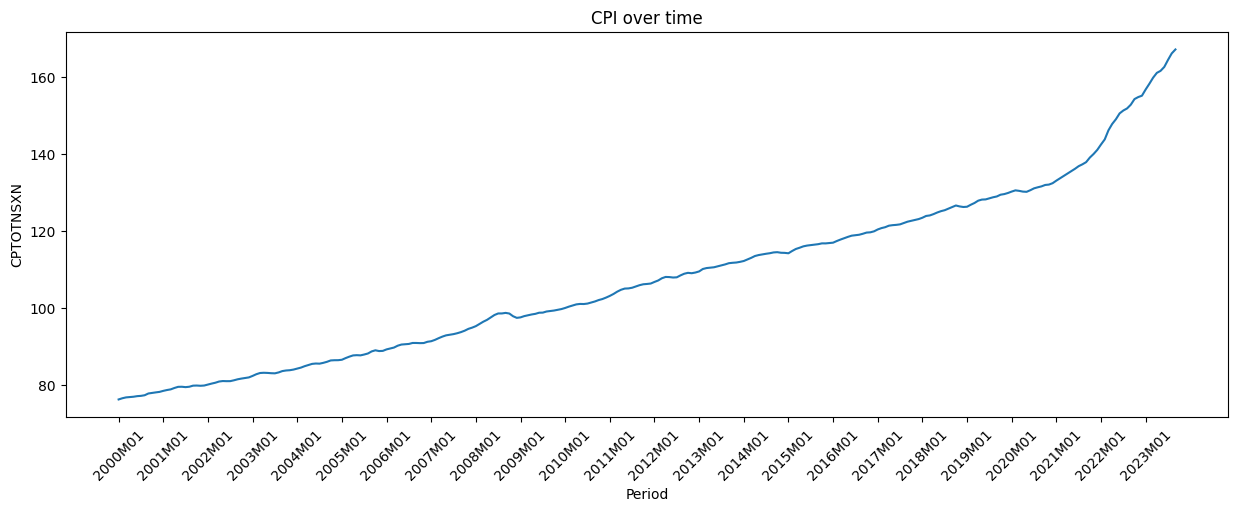

In [44]:
cpi = pd.read_csv('../data/processed/cpi.csv', encoding='unicode_escape')

# Plotting
# The consumer price index reflects the change in prices for the average consumer of a constant basket of consumer goods. Data is not seasonally adjusted.
plt.figure(figsize=(15, 5))
plt.plot(cpi['period'], cpi['CPTOTNSXN'])
plt.xlabel('Period')
plt.ylabel('CPTOTNSXN')
plt.title('CPI over time')
plt.xticks(rotation=45)

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
plt.xticks(cpi['period'][::12], rotation=45)
plt.show()


### Panal data -- EPU & Network Uncertainty

In [39]:
import pandas as pd

# Assuming your data frames are named uncertainty_3 and EPU
# Merge the data frames on the 'period' column
merged_data = pd.merge(uncertainty, epu, on='period')

# Convert 'period' column to datetime format with the specified format
merged_data['period'] = pd.to_datetime(merged_data['period'], format='%YM%m')

# Set the 'date' column as the index
# Check for missing values and handle them if necessary
merged_data.dropna(inplace=True)

# Specify the dependent variable (y) and independent variable (X)
# Adjust the column names accordingly
y = merged_data['GEPU_ppp']
X = merged_data['weighted_uncertainty']

# Add a constant to the independent variable (X) for the intercept
X = sm.add_constant(X)

# Fit the time-series model (e.g., Ordinary Least Squares)
model = sm.OLS(y, X)

# Get the results
results = model.fit()

# Display regression results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:               GEPU_ppp   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     10.61
Date:                Thu, 11 Jan 2024   Prob (F-statistic):            0.00126
Time:                        14:15:30   Log-Likelihood:                -1607.2
No. Observations:                 279   AIC:                             3218.
Df Residuals:                     277   BIC:                             3226.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  163.2363 

In [59]:
import pandas as pd
import statsmodels.api as sm

# Assuming your data frames are named uncertainty and epu
# Merge the data frames on the 'period' column
merged_data = pd.merge(uncertainty, epu, on='period')

# Convert 'period' column to datetime format with the specified format
merged_data['period'] = pd.to_datetime(merged_data['period'], format='%YM%m')

# Set the 'date' column as the index
merged_data.set_index('period', inplace=True)

# Check for missing values and handle them if necessary
merged_data.dropna(inplace=True)

# Specify the dependent variable (y) and independent variables (X)
# Include lagged values of 'GEPU_ppp' up to lag 6
lagged_columns = ['GEPU_ppp_lag1', 'GEPU_ppp_lag2', 'GEPU_ppp_lag3', 'GEPU_ppp_lag4', 'GEPU_ppp_lag5', 'GEPU_ppp_lag6']
for i in range(1, 7):
    merged_data[f'GEPU_ppp_lag{i}'] = merged_data['GEPU_ppp'].shift(i)

y = merged_data['GEPU_ppp']
X = merged_data[['weighted_uncertainty'] + lagged_columns]

# Delete the first 6 rows
merged_data = merged_data.iloc[6:]
y = y.iloc[6:]
X = X.iloc[6:]

# Add a constant to the independent variable (X) for the intercept
X = sm.add_constant(X)

# Fit the time-series model (e.g., Ordinary Least Squares)
model = sm.OLS(y, X)

# Get the results
results = model.fit()

# Display regression results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:               GEPU_ppp   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     252.8
Date:                Thu, 11 Jan 2024   Prob (F-statistic):          2.28e-113
Time:                        15:13:05   Log-Likelihood:                -1299.5
No. Observations:                 273   AIC:                             2615.
Df Residuals:                     265   BIC:                             2644.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    7.8556 

In [58]:
merged_data

,avg_uncertainty,weighted_uncertainty,GEPU_current,GEPU_ppp,GEPU_ppp_lag1,GEPU_ppp_lag2,GEPU_ppp_lag3,GEPU_ppp_lag4,GEPU_ppp_lag5,GEPU_ppp_lag6
period,,,,,,,,,,
2000-07-01,0.266907,0.521173,65.123934,58.564543,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-01,1.106437,4.507290,54.240162,51.716876,58.564543,NaN,NaN,NaN,NaN,NaN
2000-09-01,0.958618,4.257233,61.000065,62.403481,51.716876,58.564543,NaN,NaN,NaN,NaN
2000-10-01,1.007439,4.065926,68.943894,67.955256,62.403481,51.716876,58.564543,NaN,NaN,NaN
2000-11-01,0.395912,1.637175,109.420868,105.108489,67.955256,62.403481,51.716876,58.564543,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-05-01,0.082846,0.299682,228.814279,227.546243,246.230843,326.531646,257.378647,258.962975,274.090639,341.865444
2023-06-01,0.130620,0.516482,231.438806,240.770257,227.546243,246.230843,326.531646,257.378647,258.962975,274.090639
2023-07-01,0.154649,0.400961,228.340938,238.605431,240.770257,227.546243,246.230843,326.531646,257.378647,258.962975


In [40]:
import pandas as pd

# Assuming your data frames are named uncertainty_3 and EPU
# Merge the data frames on the 'period' column
merged_data = pd.merge(uncertainty, trade_volume, on='period')

# Convert 'period' column to datetime format with the specified format
merged_data['period'] = pd.to_datetime(merged_data['period'], format='%YM%m')

# Set the 'date' column as the index
# Check for missing values and handle them if necessary
merged_data.dropna(inplace=True)

# Specify the dependent variable (y) and independent variable (X)
# Adjust the column names accordingly
y = merged_data['PrimaryValue']
X = merged_data['weighted_uncertainty']  ##

# Add a constant to the independent variable (X) for the intercept
X = sm.add_constant(X)

# Fit the time-series model (e.g., Ordinary Least Squares)
model = sm.OLS(y, X)

# Get the results
results = model.fit()

# Display regression results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           PrimaryValue   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     24.56
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           1.26e-06
Time:                        14:15:48   Log-Likelihood:                -7038.8
No. Observations:                 279   AIC:                         1.408e+04
Df Residuals:                     277   BIC:                         1.409e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3.103e+10 

In [60]:
# Include the lags

# Assuming your data frames are named uncertainty and epu
# Merge the data frames on the 'period' column
merged_data = pd.merge(uncertainty, trade_volume, on='period')

# Convert 'period' column to datetime format with the specified format
merged_data['period'] = pd.to_datetime(merged_data['period'], format='%YM%m')

# Set the 'date' column as the index
merged_data.set_index('period', inplace=True)

# Check for missing values and handle them if necessary
merged_data.dropna(inplace=True)

# Specify the dependent variable (y) and independent variables (X)
# Include lagged values of 'GEPU_ppp' up to lag 6
lagged_columns = ['PrimaryValue_lag1', 'PrimaryValue_lag2', 'PrimaryValue_lag3', 'PrimaryValue_lag4', 'PrimaryValue_lag5', 'PrimaryValue_lag6']
for i in range(1, 7):
    merged_data[f'PrimaryValue_lag{i}'] = merged_data['PrimaryValue'].shift(i)

y = merged_data['PrimaryValue']
X = merged_data[['weighted_uncertainty'] + lagged_columns]

# Delete the first 6 rows
merged_data = merged_data.iloc[6:]
y = y.iloc[6:]
X = X.iloc[6:]

# Add a constant to the independent variable (X) for the intercept
X = sm.add_constant(X)

# Fit the time-series model (e.g., Ordinary Least Squares)
model = sm.OLS(y, X)

# Get the results
results = model.fit()

# Display regression results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           PrimaryValue   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1339.
Date:                Thu, 11 Jan 2024   Prob (F-statistic):          9.53e-203
Time:                        15:15:07   Log-Likelihood:                -6408.1
No. Observations:                 273   AIC:                         1.283e+04
Df Residuals:                     265   BIC:                         1.286e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.341e+08 

In [45]:

# Assuming your data frames are named uncertainty_3 and EPU
# Merge the data frames on the 'period' column
merged_data = pd.merge(uncertainty, cpi, on='period')

# Convert 'period' column to datetime format with the specified format
merged_data['period'] = pd.to_datetime(merged_data['period'], format='%YM%m')

# Set the 'date' column as the index
# Check for missing values and handle them if necessary
merged_data.dropna(inplace=True)

# Specify the dependent variable (y) and independent variable (X)
# Adjust the column names accordingly
y = merged_data['CPTOTNSXN']
X =  merged_data['weighted_uncertainty']

# Add a constant to the independent variable (X) for the intercept
X = sm.add_constant(X)

# Fit the time-series model (e.g., Ordinary Least Squares)
model = sm.OLS(y, X)

# Get the results
results = model.fit()

# Display regression results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              CPTOTNSXN   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     17.12
Date:                Thu, 11 Jan 2024   Prob (F-statistic):           4.65e-05
Time:                        14:58:00   Log-Likelihood:                -1244.1
No. Observations:                 279   AIC:                             2492.
Df Residuals:                     277   BIC:                             2500.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  113.2054 

In [61]:
# Include the lags

# Assuming your data frames are named uncertainty and epu
# Merge the data frames on the 'period' column
merged_data = pd.merge(uncertainty, cpi, on='period')

# Convert 'period' column to datetime format with the specified format
merged_data['period'] = pd.to_datetime(merged_data['period'], format='%YM%m')

# Set the 'date' column as the index
merged_data.set_index('period', inplace=True)

# Check for missing values and handle them if necessary
merged_data.dropna(inplace=True)

# Specify the dependent variable (y) and independent variables (X)
# Include lagged values of 'GEPU_ppp' up to lag 6
lagged_columns = ['CPTOTNSXN_lag1', 'CPTOTNSXN_lag2', 'CPTOTNSXN_lag3', 'CPTOTNSXN_lag4', 'CPTOTNSXN_lag5', 'CPTOTNSXN_lag6']
for i in range(1, 7):
    merged_data[f'CPTOTNSXN_lag{i}'] = merged_data['CPTOTNSXN'].shift(i)

y = merged_data['CPTOTNSXN']
X = merged_data[['weighted_uncertainty'] + lagged_columns]

# Delete the first 6 rows
merged_data = merged_data.iloc[6:]
y = y.iloc[6:]
X = X.iloc[6:]

# Add a constant to the independent variable (X) for the intercept
X = sm.add_constant(X)

# Fit the time-series model (e.g., Ordinary Least Squares)
model = sm.OLS(y, X)

# Get the results
results = model.fit()

# Display regression results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              CPTOTNSXN   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.694e+05
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:16:37   Log-Likelihood:                 31.642
No. Observations:                 273   AIC:                            -47.28
Df Residuals:                     265   BIC:                            -18.41
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1941 

In [ ]:
# unit root test and co-integration test for stationary